In [1]:
%load_ext autoreload
%autoreload 2

In [317]:
import albumentations as A
from albumentations.pytorch import transforms
from fastai2.vision.all import get_image_files, AdaptiveConcatPool2d, \
    aug_transforms, show_image, show_images, load_image, PoolFlatten, \
    PoolType
from itertools import zip_longest
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning.logging.comet import CometLogger
from pytorch_lightning.loggers import MLFlowLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision as tv
import warnings

from htools import *
from incendio.optimizers import variable_lr_optimizer
from img_wang.data import get_databunch, load_img
from img_wang.models import Unmixer, Encoder

In [18]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [350]:
class UnmixerPL(pl.LightningModule):
    
    def __init__(self, net=None, loss=F.mse_loss):
        super().__init__()
        self.net = net or Unmixer()
        self.loss = loss
        
    def forward(self, *x):
        return self.net(*x)
    
    def training_step(self, batch, batch_i):
        *x, y = batch
        y_hat = self(*x)
        loss = self.loss(y_hat, y)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_i):
        *x, y = batch
        y_hat = self(*x)
        loss = self.loss(y_hat, y)
        res = pl.EvalResult(checkpoint_on=loss)
        res.log('val_loss', loss)
        return res
    
    def configure_optimizers(self):
        return variable_lr_optimizer(self.net)

In [21]:
class MixupDataPL(pl.LightningDataModule):
    
    def __init__(self, dir_=None, paths=None,
                 mode:('mixup', 'scale', 'quadrant')='mixup', bs=32,
                 valid_bs_mult=1, train_pct=.9, shuffle_train=True,
                 drop_last=True, random_state=0, **ds_kwargs):
        self.dst, self.dsv, self.dlt, self.dlv = get_databunch(
            dir_, paths, mode, bs, valid_bs_mult, train_pct, shuffle_train,
            drop_last, random_state, **ds_kwargs
        )
        
    def train_dataloader(self):
        return self.dlt
    
    def val_dataloader(self):
        return self.dlv

In [6]:
dir_u = Path('data/imagewang-160/unsup/')

In [11]:
paths_xtiny = get_image_files(dir_u)[:4]
data = MixupDataPL(paths=paths_xtiny, mode='scale', bs=2, train_pct=.5, n=1)
module = UnmixerPL()

In [12]:
with open('/Users/hmamin/.comet.config', 'r') as f:
    comet_key = f.readlines()[-1].split('=')[-1].strip()
logger = CometLogger(api_key=comet_key, project_name='imagewang')

CometLogger will be initialized in online mode


In [13]:
mlf_logger = MLFlowLogger(experiment_name='debug-img-wang', 
                          tracking_uri='http://127.0.0.1:5000')

In [14]:
t = pl.Trainer(max_epochs=5, logger=mlf_logger, log_save_interval=1)
t.fit(module, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type    | Params
---------------------------------
0 | net  | Unmixer | 394 K 


1

## Supervised Task

Try out the slightly more straightforward supervised task to see if that trains as expected with incendio and/or lightning. Trying to narrow down possible problems.

In [138]:
x = load_image('data/imagewang-160/train/n01440764/ILSVRC2012_val_00000293.jpeg')
x = np.array(x, dtype=np.float32)

In [330]:
class SupervisedDataPL(pl.LightningDataModule):
    
    def __init__(self, root='data/imagewang-160', bs=32, train_tfms=None,
                 val_tfms=None, shape=(128, 128)):
        """
        tfms: list[transform]
        """
        self.root = Path(root)
        self.bs = bs
        self.train_tfms = tv.transforms.Compose(
            train_tfms or 
            [tv.transforms.RandomResizedCrop(shape, (.9, 1.0)), 
             tv.transforms.RandomHorizontalFlip(),
             tv.transforms.RandomRotation(10),
             tv.transforms.ToTensor()]
        )
        self.val_tfms = tv.transforms.Compose(
            val_tfms or 
            [tv.transforms.Resize(shape),
             tv.transforms.ToTensor()])
        
    def setup(self, stage=''):
        self.ds_train = ImageFolder(self.root/'train', self.train_tfms)
        self.ds_val = ImageFolder(self.root/'val', self.val_tfms)
        self.ds_val.classes = self.ds_train.classes
        self.ds_val.class_to_idx = self.ds_train.class_to_idx
        self.dl_train = DataLoader(self.ds_train, self.bs, shuffle=True)
        self.dl_val = DataLoader(self.ds_val, self.bs)
        
    def train_dataloader(self):
        return self.dl_train
    
    def val_dataloader(self):
        return self.dl_val

In [331]:
class SupervisedEncoderClassifier(nn.Module):
    
    def __init__(self, enc=None, enc_out_feat=None, n_classes=20):
        super().__init__()
        self.n_classes = n_classes
        
        # Layers
        self.enc = enc or Encoder()
        self.pool = PoolFlatten('cat')
        # Concat pool doubles last feature dimension.
        self.fc = nn.Linear(list(self.enc.parameters())[-1].shape[0]*2,
                            n_classes)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.pool(x)
        return self.fc(x).squeeze()

In [332]:
sdata = SupervisedDataPL(bs=2)
sdata.setup()

In [333]:
net = SupervisedEncoderClassifier()

In [334]:
x, y = next(iter(sdata.dl_train))
x.shape, y.shape

(torch.Size([2, 3, 128, 128]), torch.Size([2]))

In [336]:
yhat = net(x)
yhat.shape

torch.Size([2, 20])

In [340]:
yhat.dtype, y.dtype

(torch.float32, torch.int64)

In [351]:
module = UnmixerPL(net, loss=F.cross_entropy)

In [352]:
t = pl.Trainer(max_epochs=5, overfit_batches=1)
t.fit(module, sdata)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type                        | Params
-----------------------------------------------------
0 | net  | SupervisedEncoderClassifier | 404 K 


/Users/hmamin/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:22: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

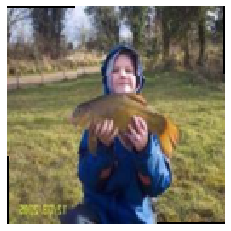

In [355]:
show_image(x[0])

In [356]:
with torch.no_grad():
    yhat = net(x)

In [360]:
F.softmax(yhat, dim=-1).argmax(-1)

tensor([18, 18])

In [361]:
y

tensor([0, 0])

## Incendio

In [385]:
from copy import copy

from incendio.core import Trainer

In [415]:
np.random.randint(0, len(sdata.ds_train), 3)

array([8254, 6165, 7795])

In [434]:
def ds_subset(ds, n, random=False, attr='samples'):
    ds = copy(ds)
    samples = getattr(ds, attr)
    setattr(ds, attr, [samples[i] for i in np.random.randint(0, len(ds), n)] \
            if random else samples[:n])
    return ds

In [437]:
dst = ds_subset(sdata.ds_train, 40, True)
dsv = ds_subset(sdata.ds_val, 4, True)
dst

Dataset ImageFolder
    Number of datapoints: 40
    Root location: data/imagewang-160/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(128, 128), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )

In [438]:
train_bs, val_bs = 8, 4
# No shuffling for debugging purposes.
dlt = DataLoader(dst, batch_size=train_bs, shuffle=False)
dlv = DataLoader(dsv, batch_size=val_bs, shuffle=False)

In [439]:
for *x, y in dlt:
    print(smap(*x, y), y)

[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([14, 15,  8, 17, 14,  0,  1,  8])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([16, 15,  8, 14, 14, 12, 14, 13])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 8, 13, 18,  8,  8, 15, 13,  0])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([18, 16, 15, 18, 11, 14, 14, 15])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([10, 17, 15, 15, 12,  0, 14, 14])


In [440]:
net = SupervisedEncoderClassifier()

In [441]:
t = Trainer(net, dst, dsv, dlt, dlv, F.cross_entropy, 'multiclass', 
            'data/models/v0')

In [442]:
t.fit(10)

2020-08-15 23:15:18,657 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-15 23:15:20,367
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  3.5978 |       3.0423 |

=====




2020-08-15 23:15:22,601
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0457 |       4.7251 |

=====




2020-08-15 23:15:24,867
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.5868 |       5.0436 |

=====




2020-08-15 23:15:27,515
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.3469 |       4.7424 |

=====




2020-08-15 23:15:29,797
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.1580 |       4.7005 |

=====




2020-08-15 23:15:31,752
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.0070 |       5.0885 |

=====




2020-08-15 23:15:33,580
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7909 |       4.7962 |

=====




2020-08-15 23:15:35,467
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7043 |       4.5786 |

=====




2020-08-15 23:15:37,684
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5834 |       6.2987 |

=====




2020-08-15 23:15:39,805
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5468 |       5.8891 |

=====

2020-08-15 23:15:39,820
 Training complete. Model in eval mode.


In [443]:
*x, y = next(iter(dlt))
smap(*x, y)

[torch.Size([8, 3, 128, 128]), torch.Size([8])]

In [444]:
y

tensor([14, 15,  8, 17, 14,  0,  1,  8])

In [446]:
F.softmax(net(*x), dim=-1).argmax(-1)

tensor([14, 15, 18, 15, 14,  0, 12,  8])

In [447]:
F.cross_entropy(net(*x), y)

tensor(1.0842, grad_fn=<NllLossBackward>)